# **Diffusion Model in Causal Inference with Unmeasured Confounders**
## **Tatsuhiro Shimizu**
## ***AI Lab, CyberAgent Tokyo, Japan***
## **0009-0009-9746-3346**

This is the code for the Example 11. in the main text.
The following image is the SCM that we implement.

- <font color='red'>Unobserved nodes: $X_1, X_4$</font>
- Cause node: $X_2$
- Outcome node: $X_5$
- Node that satisfies the backdoor criterion for a pair $(X_2, X_5)$: $X_3$

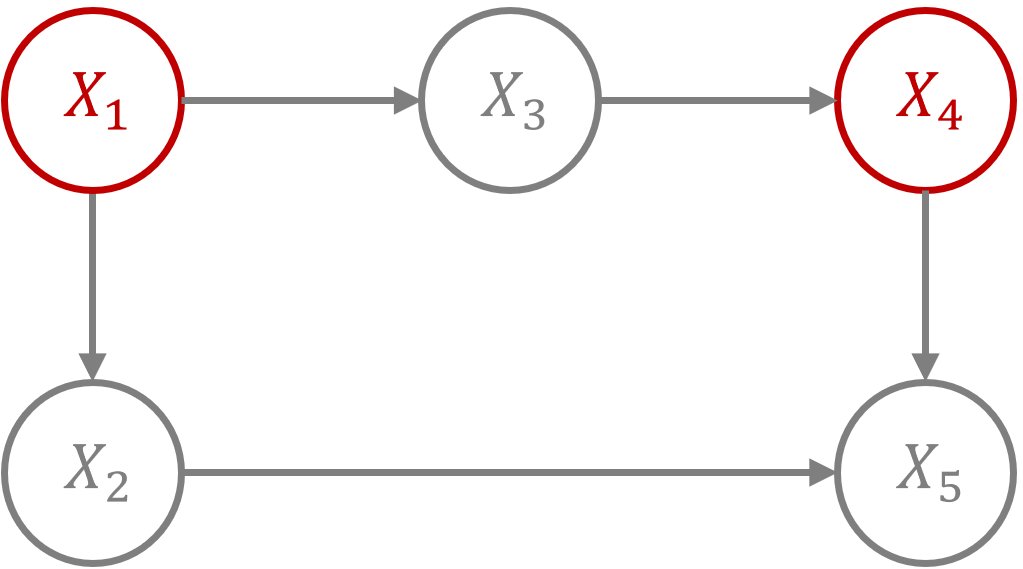

Define
- the number of observation: n_obs = 1000 (same environment as the DCM paper)
- the number of samples from DCM and BDCM: n_sample_DCM = 500 (same environment as the DCM paper)

## DCM Training

Define
- time: $T = 100$
- noise schedule: $\beta_t$ and $\alpha_t$ for all $i = 1, \cdots, T$

Define
- the structural equation: $X_i = f(PA(X_i)) + U_i$
  - $X_1 = U_1$
  - $X_2 = \frac{\sqrt{|X_1|} (|U_2| + 0.1)}{2} + |X_1| + \frac{U_2}{5}$
  - $X_3 = \frac{1}{1 + (|U_3| + 0.1) \exp(-X_2)}$
  - $X_4 = X_3 + X_3 U_4 + U_4$
  - $X_5 = X_2 + X_4 + X_2 X_4 U_5 + U_5$
- number of internvened values
- intervened values

Sample
- exogeneous nodes: $U_1, U_2, U_3, U_4, U_5 \sim \mathcal{N}(0, 1)$
- endogenous nodes: $X_1, X_2, X_3, X_4, X_5$
- intervened nodes: $X_5|do(X_2 = x_2)$
- time: $t \sim \mathcal{N}(0, 1)$
- noise: $\epsilon \sim \mathcal{N}(0, 1)$


Define
- epoch: num_epochs = 500
- batch size: batch_size = 64
- learning rate: learning_rate $\eta$ = 0.0001

Neural Network: 3 hidden layers
- 1st layer: 128 nodes
- 2nd layer: 256 nodes
- 3rd layer: 256 nodes

Train the Neural Network

Plot the loss of the training over the epoch

In [1]:
# Import libraries
import numpy as np

import torch
import torch.nn.functional
import torch.utils.data
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.ioff()  # 対話モードを無効にする

# Warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from func import normalize
from SCM1 import SCM1


  0%|          | 0/2 [00:00<?, ?it/s]

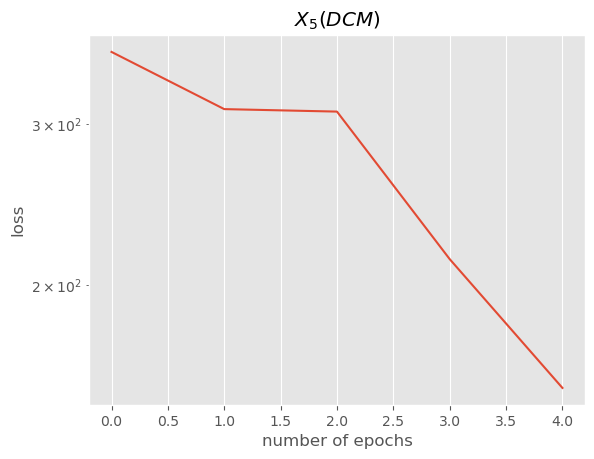

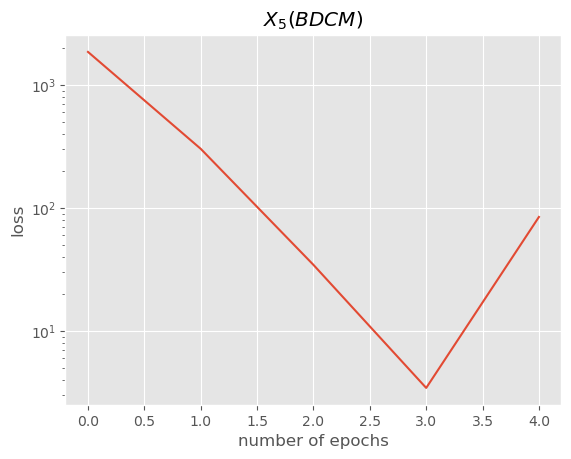

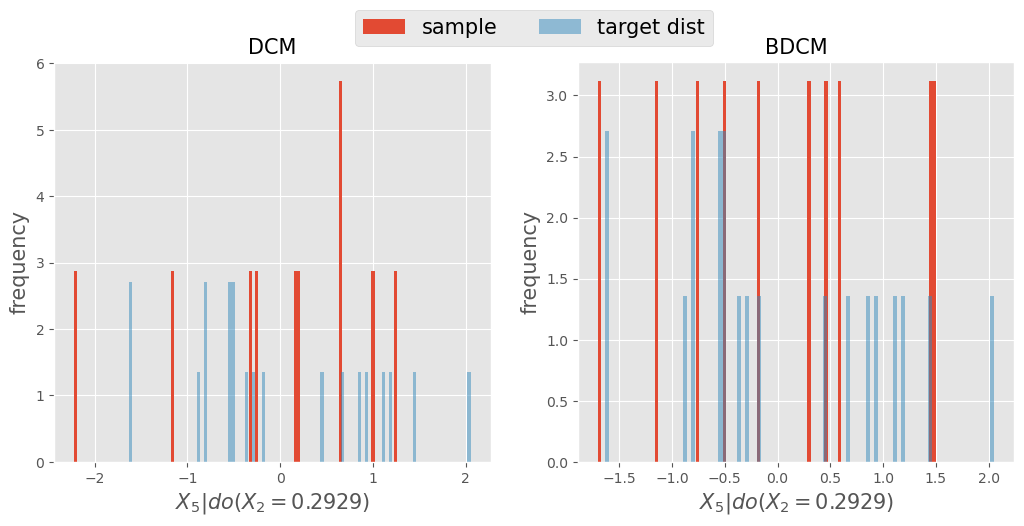

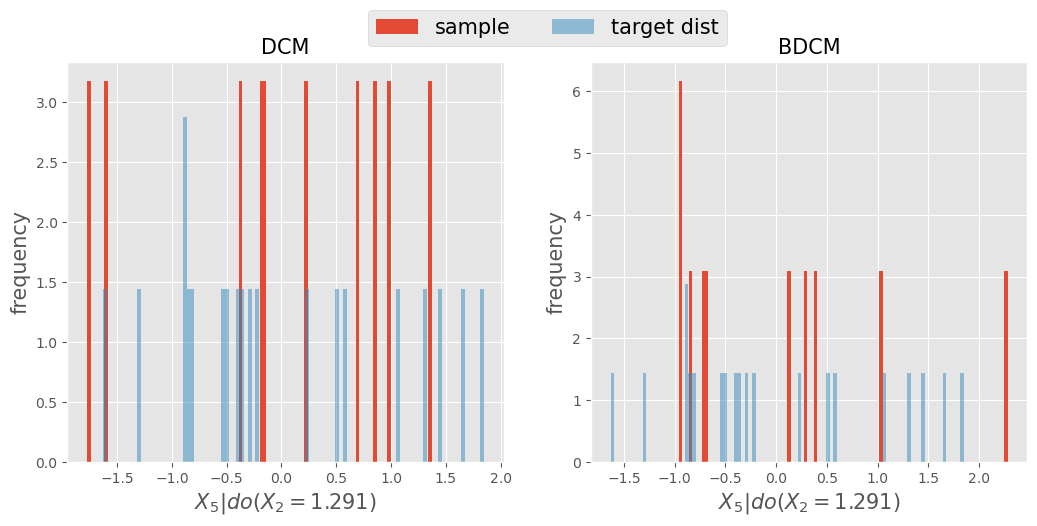

 50%|█████     | 1/2 [00:01<00:01,  1.66s/it]

mean of MMD for DCM: 0.00398
standard deviation of MMD for DCM: 0.002
mean of MMD for BDCM: 0.00409
standard deviation of MMD for BDCM: 8.28e-05


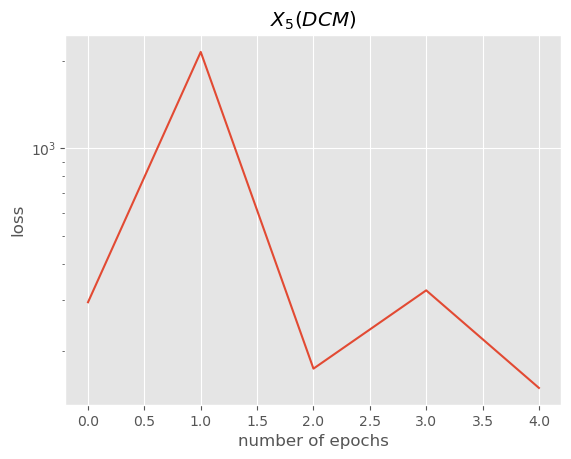

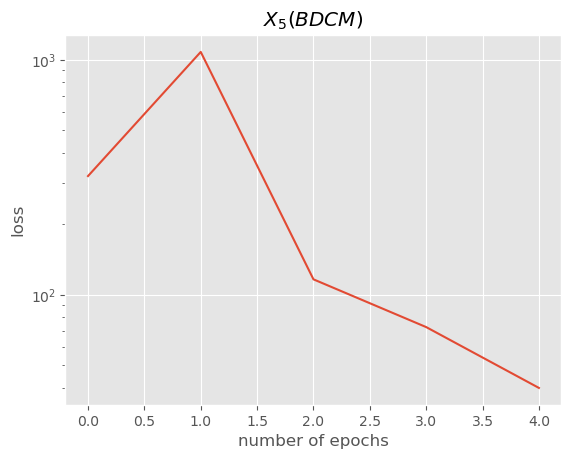

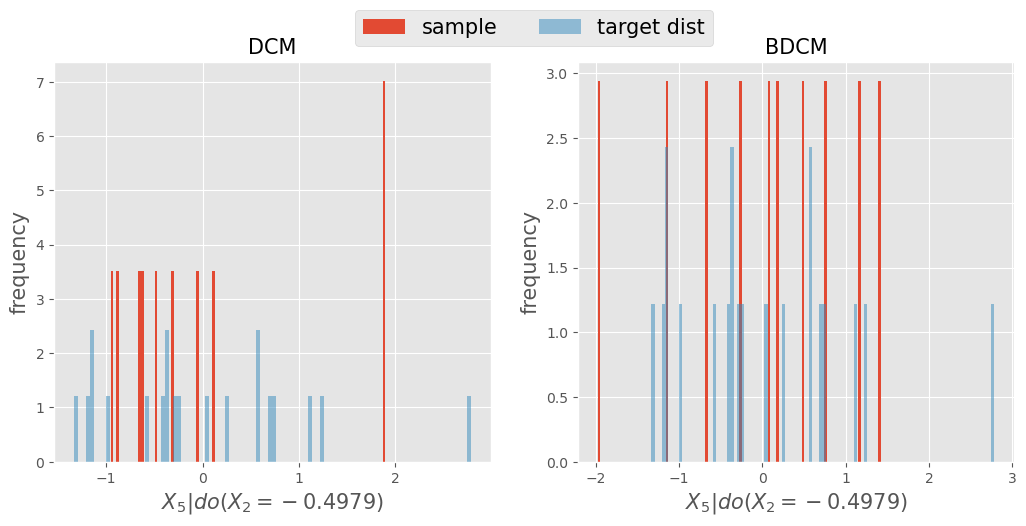

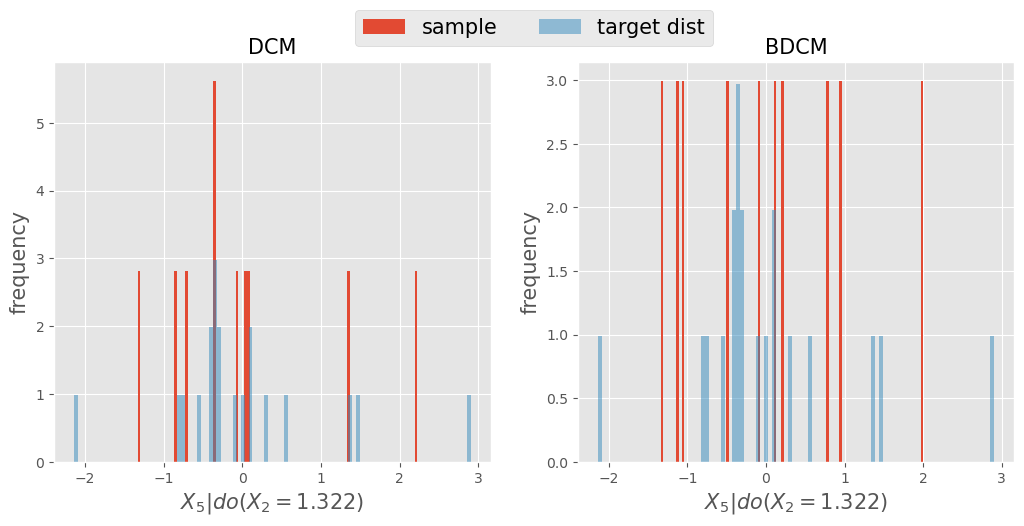

100%|██████████| 2/2 [00:03<00:00,  1.56s/it]

mean of MMD for DCM: 0.0174
standard deviation of MMD for DCM: 0.0137
mean of MMD for BDCM: 0.0134
standard deviation of MMD for BDCM: 0.0102
mean of all MMD for DCM: 0.0107
standard deviation of all MMD for DCM: 0.0118
mean of all MMD for BDCM: 0.00875
standard deviation of all MMD for BDCM: 0.00861


In [2]:
# Define the structual equation
# X_i = f_i(X_{pa_i}) + U_i

def structural_eq(u, ind, x):
    if ind == 0:
        output = u
    elif ind == 1:
        output = np.sqrt(abs(x[0])) * (abs(u) + 0.1) / 2 + abs(x[0]) + u / 5
    elif ind == 2:
        output = 1 / (1 + (abs(u) + 0.1) * np.exp(- x[1]))
    elif ind == 3:
        output = x[2] + x[2] * u + u
    elif ind == 4:
        output = x[1] + x[3] + x[1] * x[3] * u + u
    return normalize(output)

SCM1(structural_eq=structural_eq, simple_or_complex = "complex")